# Anomalies in Streaming Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn import preprocessing
from matplotlib import pyplot as plt

# 1. Read the dataset

In [3]:
df = pd.read_csv('./drive/MyDrive/Colab Notebooks/ts-regression/data/ambient_temperature_system_failure.csv')
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


# 2. Preprocess the dataset

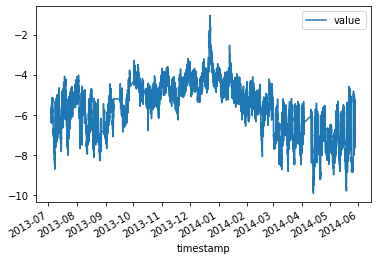

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5 / 9
df.plot(x='timestamp', y='value')

### Create four additional features

In [6]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & 
                  (df['hours'] <= 22)).astype(int)
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['weekday'] = (df['dayofweek'] < 5).astype(int)

In [13]:
pd.set_option('display.max_columns', None)
#pd.reset_option('all')
#pd.set_option('display.max_rows', 400)
#pd.set_option('display.min_rows', 100)
df.loc[:, ['timestamp','hours','dayofweek']]
#df.iloc[:, [2, 3, 4]]

,timestamp,hours,dayofweek
0,2013-07-04 00:00:00,0,3
1,2013-07-04 01:00:00,1,3
2,2013-07-04 02:00:00,2,3
3,2013-07-04 03:00:00,3,3
4,2013-07-04 04:00:00,4,3
...,...,...,...
7262,2014-05-28 11:00:00,11,2
7263,2014-05-28 12:00:00,12,2
7264,2014-05-28 13:00:00,13,2
7265,2014-05-28 14:00:00,14,2


### Standardize the added features

In [16]:
data_n = df[['value', 'hours', 'daylight', 
             'dayofweek', 'weekday']]
print(data_n)
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(data_n)
data_n = pd.DataFrame(scaled)
print(scaler.mean_)
print(data_n)

         value  hours  daylight  dayofweek  weekday
0    -6.086162      0         0          3        1
1    -5.672769      1         0          3        1
2    -5.778455      2         0          3        1
3    -6.370556      3         0          3        1
4    -6.270509      4         0          3        1
...        ...    ...       ...        ...      ...
7262 -5.317838     11         1          2        1
7263 -5.378717     12         1          2        1
7264 -5.417727     13         1          2        1
7265 -5.486041     14         1          2        1
7266 -5.251825     15         1          2        1

[7267 rows x 5 columns]
[-5.66591583 11.50928856  0.66685014  2.98857851  0.72148067]
             0         1         2         3        4
0    -0.320586 -1.661537 -1.414798  0.005769  0.62132
1    -0.005228 -1.517172 -1.414798  0.005769  0.62132
2    -0.085851 -1.372807 -1.414798  0.005769  0.62132
3    -0.537536 -1.228442 -1.414798  0.005769  0.62132
4    -0.461215 -1.0

### Unroll the features

In [17]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,length=50):
    result = []
    for i in range(len(data) - length + 1):
        result.append(data[i : i + length])
    return np.asarray(result)

In [18]:
X = data_n[:-1].values
X = unroll(X, length = 50)
print(f"X shape: {X.shape}")

X shape: (7217, 50, 5)


In [21]:
y = data_n[1:][0].values
y = y[-X.shape[0]:]

print(f"Y shape: {y.shape}")

Y shape: (7217,)


In [22]:
test_size = 1000

X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]

In [23]:
# see the shape
print(f"x_train: {X_train.shape} " 
      f"y_train: {y_train.shape}")

print(f"x_test : {X_test.shape} "
      f"y_test : {y_test.shape}")

x_train: (6217, 50, 5) y_train: (6217,)
x_test : (1000, 50, 5) y_test : (1000,)


# 3. Now make the RNN model to predict

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

#### (a) Define LSTM models

In [43]:
from tensorflow.keras.layers import InputLayer
def create_lstm(pkeep):
    # Build the model
    model = Sequential()
    model.add(InputLayer(input_shape=(50,5)))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(1-pkeep))
    model.add(LSTM(100))
    model.add(Dropout(1-pkeep))
    model.add(Dense(units=1)) # Dense( Input/ output) W (I * O)
    model.summary()
    return model

#### (b) Train the model
* Configure the epoch and batch size 
* Set loss function and optimizer
* Train the model

In [26]:
pkeep = 0.8
batch_size = 512
epochs = 100

In [44]:
model = create_lstm(pkeep=pkeep)
model.compile(loss = 'mse', optimizer = 'adam')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 50, 50)            11200     
                                                                 
 dropout_14 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_17 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 71,701
Trainable params: 71,701
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Train the model
model.fit(X_train, y_train, batch_size=batch_size, 
          epochs=epochs, validation_split=0.1, 
          callbacks=[EarlyStopping(monitor="val_loss", patience=10)])

Epoch 1/100
11/11 [==============================] - 8s 110ms/step - loss: 0.3279 - val_loss: 0.2615
Epoch 2/100
11/11 [==============================] - 0s 16ms/step - loss: 0.1029 - val_loss: 0.1768
Epoch 3/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0806 - val_loss: 0.1848
Epoch 4/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0671 - val_loss: 0.1232
Epoch 5/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0603 - val_loss: 0.1173
Epoch 6/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0569 - val_loss: 0.0987
Epoch 7/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0560 - val_loss: 0.0963
Epoch 8/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0545 - val_loss: 0.0971
Epoch 9/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0532 - val_loss: 0.0882
Epoch 10/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0516 - val_loss: 0.091

#### (c) Check the result and detect 10 anomalies with maximum differences 
* Compute the differences for the test instances (absolute value).
    
* Plot the true and predicted value using `matplotlib`.
    
* Find the 10 anomalies and plot into the previus figure.



In [46]:
preds = model.predict(X_test)
print(preds.shape)
diffs = list(abs(y_test - preds.flatten()))

(1000, 1)


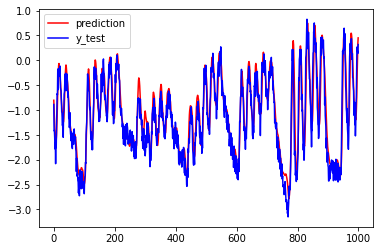

In [ ]:
fig, axs = plt.subplots()
axs.plot(preds, color='red', label='prediction')
axs.plot(y_test, color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [ ]:
n_outliers = 10
argsorted = np.array(diffs).argsort()
anomalies = argsorted[-n_outliers:][::-1]
print(anomalies)

[790 789 827 850 300 948 781 851 971 995]


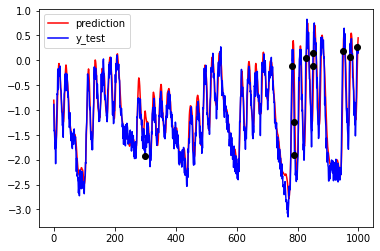

In [ ]:
fig, axs = plt.subplots()

axs.plot(preds, color='red', label='prediction')
axs.plot(y_test, color='blue', label='y_test')
axs.scatter(anomalies, [y_test[i] for i in anomalies],
        color='black', zorder=10)
plt.legend(loc='upper left')
plt.show()